### Outliers detection

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import pandas as pd
#Visualization
import plotly.express as px
import plotly.figure_factory as ff
import plotly.subplots as sp
import plotly.graph_objs as go


In [ ]:
df = pd.read_csv("balanced_dataset.csv")

### Correct protocol type column

In [ ]:
df_protocols = pd.read_csv('protocol-numbers-1.csv')
df_protocols.head()

,Decimal,Keyword,Protocol,IPv6 Extension Header,Reference
0,0,HOPOPT,IPv6 Hop-by-Hop Option,Y,[RFC8200]
1,1,ICMP,Internet Control Message,NaN,[RFC792]
2,2,IGMP,Internet Group Management,NaN,[RFC1112]
3,3,GGP,Gateway-to-Gateway,NaN,[RFC823]
4,4,IPv4,IPv4 encapsulation,NaN,[RFC2003]


In [ ]:
protocols=[int(i) for i in df['Protocol Type']]
df['Protocol Type']=[p for p in protocols if p in df_protocols['Decimal']]

In [ ]:
df.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label,family
0,3.929349,531816.3,5,91.2,118.458798,118.458798,0.0,0.0,0.0,0.0,...,1947.8,5.895138e-04,5.5,57.769121,984.336310,8.458172e+05,0.7,38.5,BenignTraffic,Benign
1,14.069667,1167126.3,6,62.4,79.397178,79.397178,0.0,0.0,0.0,0.0,...,2144.8,1.819396e-03,5.5,47.671500,1451.701699,1.335229e+06,0.9,38.5,BenignTraffic,Benign
2,18.121312,183269.9,6,80.7,116.289429,116.289429,0.0,0.0,0.0,0.0,...,1233.4,1.665181e+08,13.5,48.157488,1151.171696,6.640119e+05,1.0,244.6,BenignTraffic,Benign
3,22.203657,60049.8,6,173.3,26.472761,26.472761,0.0,0.0,0.0,0.0,...,130.8,6.905985e-03,5.5,14.042566,62.574197,3.343423e+03,0.9,38.5,BenignTraffic,Benign
4,31.992701,1979773.4,6,64.0,64.141615,64.141615,0.0,0.0,0.0,0.0,...,2005.9,1.665207e+08,13.5,35.861736,1504.864113,1.418052e+06,1.0,244.6,BenignTraffic,Benign


### Outliers detection

##### Are there outliers on the target variable?


It’s best to remove outliers only when you have a sound reason for doing so. Some outliers represent natural variations in the population, and they should be left as is in your dataset. These are called true outliers. Other outliers are problematic and should be removed because they represent measurement errors, data entry or processing errors, or poor sampling.

#### Univariate outliers

In [ ]:
def univariateOutliers(df,column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    small_outliers = df[column] < (Q1 - 1.5 * IQR)
    big_outliers = df[column] > (Q3 + 1.5 * IQR)
    return [small_outliers,big_outliers]

In [ ]:
def distributionCompare(df,column):
    
    small_outliers,big_outliers = univariateOutliers(df,column)
    fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(4,2))
    axes[0].set_title('Boxplot (Original)')
    df.boxplot(column=column,ax=axes[0]);
    axes[1].set_title('Histogram (Original)')
    df.hist(column=column, ax=axes[1]);

    fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(4,2))
    axes[0].set_title('Boxplot (Without outliers)')
    df[~(small_outliers | big_outliers)].boxplot(column=column,ax=axes[0]);
    axes[1].set_title('Histogram ((Without outliers))')
    df[~(small_outliers | big_outliers)].hist(column=column, ax=axes[1]);

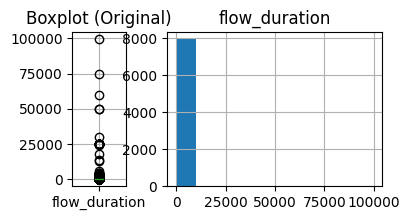

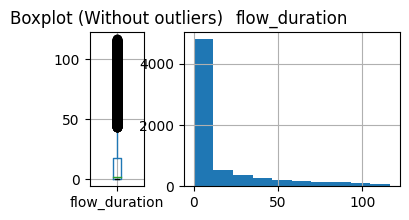

In [ ]:
distributionCompare(df,"flow_duration")

In [ ]:
import numpy as np

def detect_outliers_z_score(data, threshold=3):
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    return np.where(z_scores > threshold)


In [ ]:
# for col in numeric_df.columns:
col="flow_duration"
data=np.array(df[col])
outliers_indices = detect_outliers_z_score(data)
outliers = data[outliers_indices]
if(len(outliers)>0):
    print("VARIABLE "+ col+ "has " + str(len(outliers)) +" outliers")
    print("Outliers indices:", outliers_indices)
    print("Outliers:", outliers)

VARIABLE flow_durationhas 25 outliers
Outliers indices: (array([1131, 1158, 1211, 1229, 1248, 1327, 1435, 1463, 1512, 1631, 1646,
       1664, 1695, 1702, 1752, 1756, 1772, 1807, 1900, 5522, 5827, 6553,
       6624, 6732, 6912]),)
Outliers: [99435.76178212 24972.55928254 49879.2520252  24921.00981703
 24958.36518469 25223.4680295  24948.87126079 24955.27809463
 24868.3208699  24903.52542562 49914.70154507 24894.53327615
 24956.79111118 25045.33274562 24920.18239944 25112.99862936
 24931.44781809 25082.01475167 74586.77836425 13677.376156
 12838.59272244 24186.55173106 17638.93305182 29752.16998935
 59475.16522651]


### Local Outlier Factor

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_absolute_error

In [ ]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
X = df.select_dtypes(include=numerics)
X.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight
0,3.929349,531816.3,5,91.2,118.458798,118.458798,0.0,0.0,0.0,0.0,...,1675.261825,696.030880,1947.8,5.895138e-04,5.5,57.769121,984.336310,8.458172e+05,0.7,38.5
1,14.069667,1167126.3,6,62.4,79.397178,79.397178,0.0,0.0,0.0,0.0,...,1305.146627,1026.508116,2144.8,1.819396e-03,5.5,47.671500,1451.701699,1.335229e+06,0.9,38.5
2,18.121312,183269.9,6,80.7,116.289429,116.289429,0.0,0.0,0.0,0.0,...,1161.613768,812.449339,1233.4,1.665181e+08,13.5,48.157488,1151.171696,6.640119e+05,1.0,244.6
3,22.203657,60049.8,6,173.3,26.472761,26.472761,0.0,0.0,0.0,0.0,...,99.873452,44.246639,130.8,6.905985e-03,5.5,14.042566,62.574197,3.343423e+03,0.9,38.5
4,31.992701,1979773.4,6,64.0,64.141615,64.141615,0.0,0.0,0.0,0.0,...,703.415408,1060.893749,2005.9,1.665207e+08,13.5,35.861736,1504.864113,1.418052e+06,1.0,244.6


In [ ]:
# identify outliers in the dataset
lof = LocalOutlierFactor()
yhat = lof.fit_predict(X)
# select all rows that are not outliers
mask = (yhat != -1)
df_withoutOutliers = df.loc[mask, :]

mask = (yhat == -1)
df_outliers = df.loc[mask, :]


In [ ]:
df_outliers['family'].value_counts()

Mirai         228
DoS           213
DDoS          190
Recon         186
Web           127
BruteForce     61
Spoofing       57
Benign         50
Name: family, dtype: int64

In [ ]:
data[outliers_indices]

array([99435.76178212, 24972.55928254, 49879.2520252 , 24921.00981703,
       24958.36518469, 25223.4680295 , 24948.87126079, 24955.27809463,
       24868.3208699 , 24903.52542562, 49914.70154507, 24894.53327615,
       24956.79111118, 25045.33274562, 24920.18239944, 25112.99862936,
       24931.44781809, 25082.01475167, 74586.77836425, 13677.376156  ,
       12838.59272244, 24186.55173106, 17638.93305182, 29752.16998935,
       59475.16522651])

In [ ]:
aux=[i for i in data[outliers_indices] if i in list(df_outliers['flow_duration'])]
len(aux)

23

In [ ]:
from scipy.stats import ks_2samp

def ks_2samp_test(col):
    # Example: Comparing 'column1' between two dataframes df1 and df2
    column1_df1 = df[col]
    column1_df2 = df_withoutOutliers[col]

    # Perform Kolmogorov-Smirnov test
    statistic, p_value = ks_2samp(column1_df1, column1_df2)

    alpha = 0.05  # Set significance level
    if p_value < alpha:
        print("Reject null hypothesis: Distributions of "+ col + " are different.")
    else:
        print("Fail to reject null hypothesis: Distributions "+ col + " are the same.")


In [ ]:
for col in df.columns:
    ks_2samp_test(col)

Reject null hypothesis: Distributions of flow_duration are different.
Reject null hypothesis: Distributions of Header_Length are different.
Fail to reject null hypothesis: Distributions Protocol Type are the same.
Fail to reject null hypothesis: Distributions Duration are the same.
Fail to reject null hypothesis: Distributions Rate are the same.
Fail to reject null hypothesis: Distributions Srate are the same.
Fail to reject null hypothesis: Distributions Drate are the same.
Fail to reject null hypothesis: Distributions fin_flag_number are the same.
Fail to reject null hypothesis: Distributions syn_flag_number are the same.
Fail to reject null hypothesis: Distributions rst_flag_number are the same.
Fail to reject null hypothesis: Distributions psh_flag_number are the same.
Fail to reject null hypothesis: Distributions ack_flag_number are the same.
Fail to reject null hypothesis: Distributions ece_flag_number are the same.
Fail to reject null hypothesis: Distributions cwr_flag_number ar

In [ ]:
df_withoutOutliers.shape

(6845, 48)

In [ ]:
df_outliers.to_csv("outliers.csv", encoding='utf-8', index=False)
df_withoutOutliers.to_csv("df_withoutOutliers.csv", encoding='utf-8', index=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3a3c41eb-c99a-4899-842d-6de17d10af25' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>